# 2017 Data Analysis

This notebook is for plotting the hit rates in 2017 SpinQuest/SeaQuest data. Binning and range of the (hodoscope) plots is dependent on their station, seen here:

<img src="files/HodoscopeDimensions.png">

For the histograms, the number of bins is given by twice the number of paddles (since we are looking at plots of either Bottom/Top or Left/Right) and the range is twice the hodoscopes' width or height, respectively. This ensures that the one-dimensional plots depict the granularity of the hodoscope accurately as well as including all possible data in the range of the two hodoscope panels.

# To Do

In order to plot the hit rates in the drift chambers, need a better understanding of their geometry. At the bottom of the notebook is an example of plotting in the drift chambers, but without the geometry I'm not entirely sure their granularity and thus can't properly bin or set histogram ranges.

# Imports

In [1]:
import uproot4
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from coffea import hist

# File I/O

Concatenate all ROOT files in order to analyze together. Change path to data directory as needed

In [16]:
root = uproot4.concatenate("combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

# Plotting Routines

helper functions

In [12]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def detectorSelection(arr, detid):
    mask = (arr.detectorID== detid)
    return mask

# build detector mask
def detectorMask(arr):
    detmask = {}
    for key,item in detID_dict.items():
        for keyd,det in item['det'].items():
            if len(det)==1:
                detmask[keyd] = detectorSelection(arr,det[0])
            else:
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    return detmask

In [13]:
detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

In [18]:
def plotHodos(root):
    '''
    takes a ROOT file and plots the hit/event rate for all hodoscopes
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    detmask = detectorMask(allhits)
    
    
    # binning and range information.
    bins_range = [(46, (-162.008,162.008)),    # H1BT
                  (32, (-203.238,203.238)),    # H2BT
                  (32, (-227.518,227.518)),    # H3BT
                  (32, (-304.518,304.518)),    # H4BT
                  (40, (-140.117,140.117)),    # H1LR
                  (38, (-241.285,241.285)),    # H2LR
                  (32, (-365.797,365.797)),    # H4Y1LR
                  (32, (-365.797,365.797)),    # H4Y2LR
                  ]
    
    # get the proper binning/range for each hist
    choose_bins = 0

    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))

    for dets,item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            maskedhits_det = maskedhits[detmask[det]]
            numpos = ak.num(maskedhits_det.pos)
            # weights -> hits/event. NOTE: need to turn awkward array to numpy array first
            ws = np.ones_like(ak.to_numpy(ak.flatten(maskedhits_det.pos)))/nevents
            if (choose_bins==3) or (choose_bins==6) or (choose_bins==7):
                # divide weights by 2, since st4 hodos count 2 hits for every one actual hit
                ws /= 2
            
            title = "Hits/Event in {}".format(det)
            savename = det+"_"+"_hitsPerEvent2017"

            fig = plt.figure(dpi=300)
            plt.hist(ak.flatten(maskedhits_det.pos), bins=bins_range[choose_bins][0],
                     range=bins_range[choose_bins][1], histtype='step', weights=ws)
            plt.ylabel("Hits/Event")
            plt.xlabel("Position %s [cm]"%direction)
            plt.title(title)
            #plt.savefig(savename)
            plt.show()
            
            choose_bins += 1

# Plotting Hodoscopes

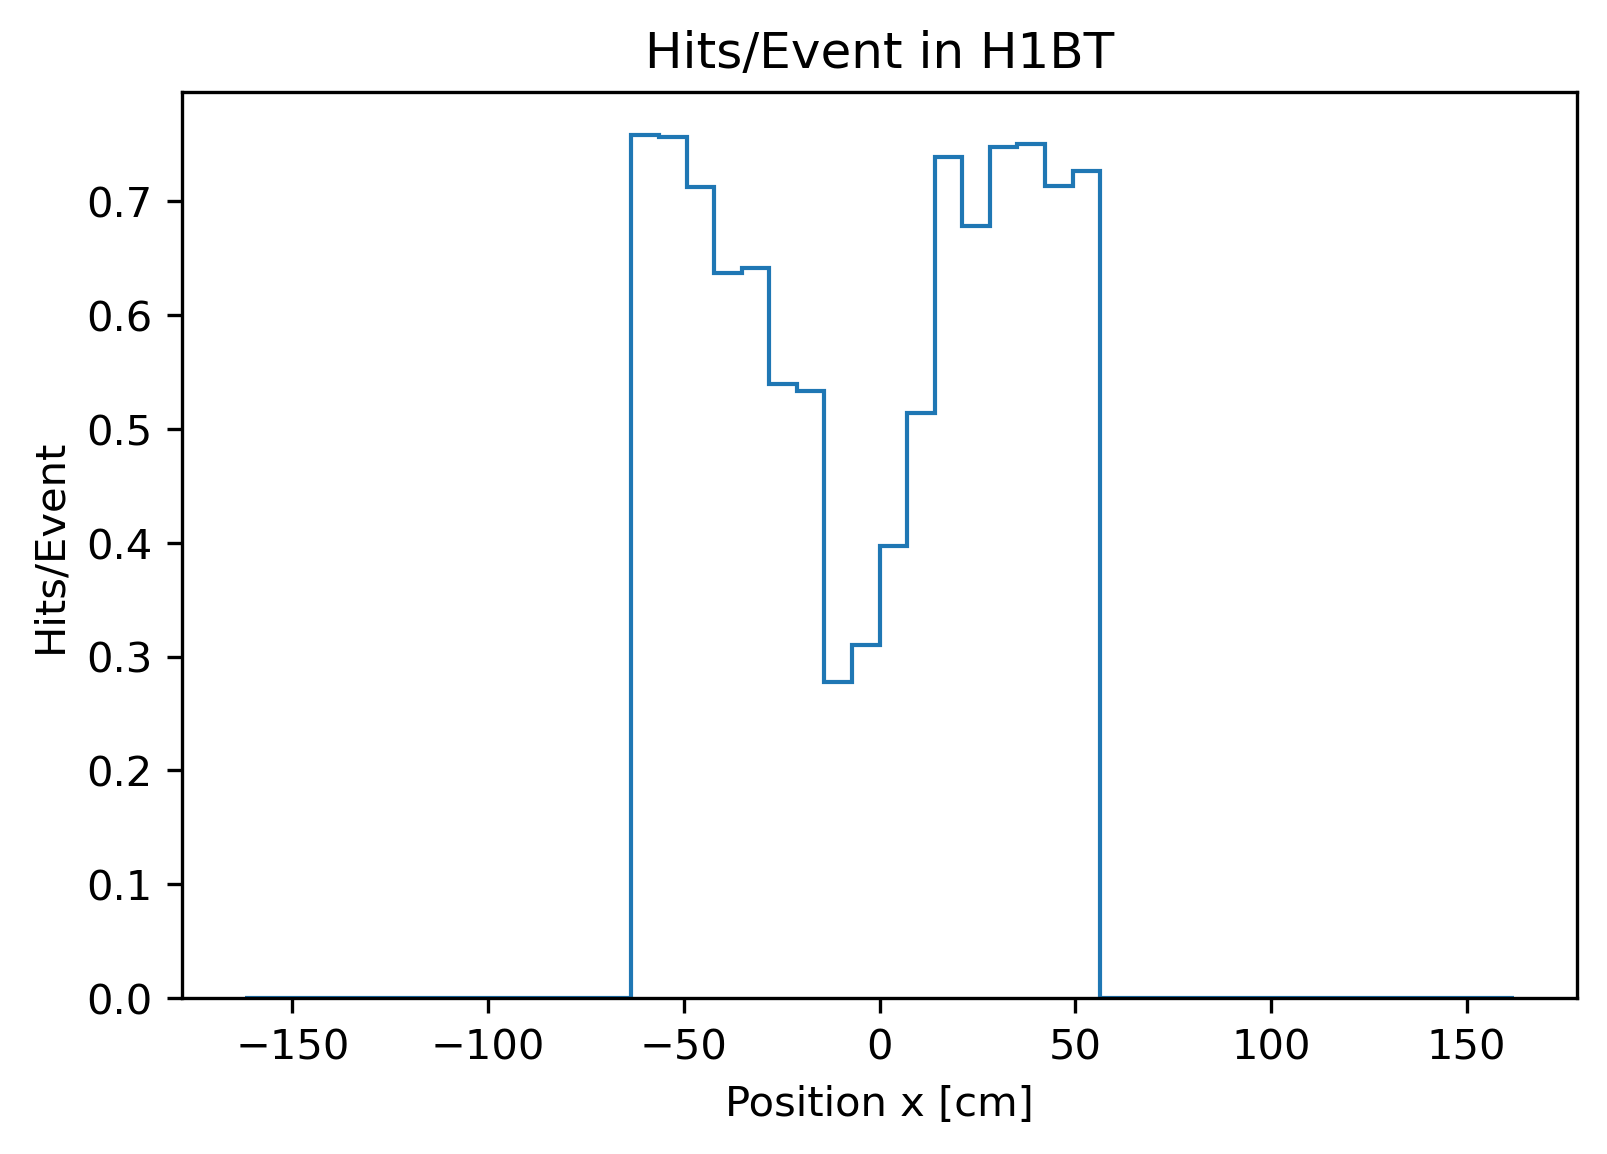

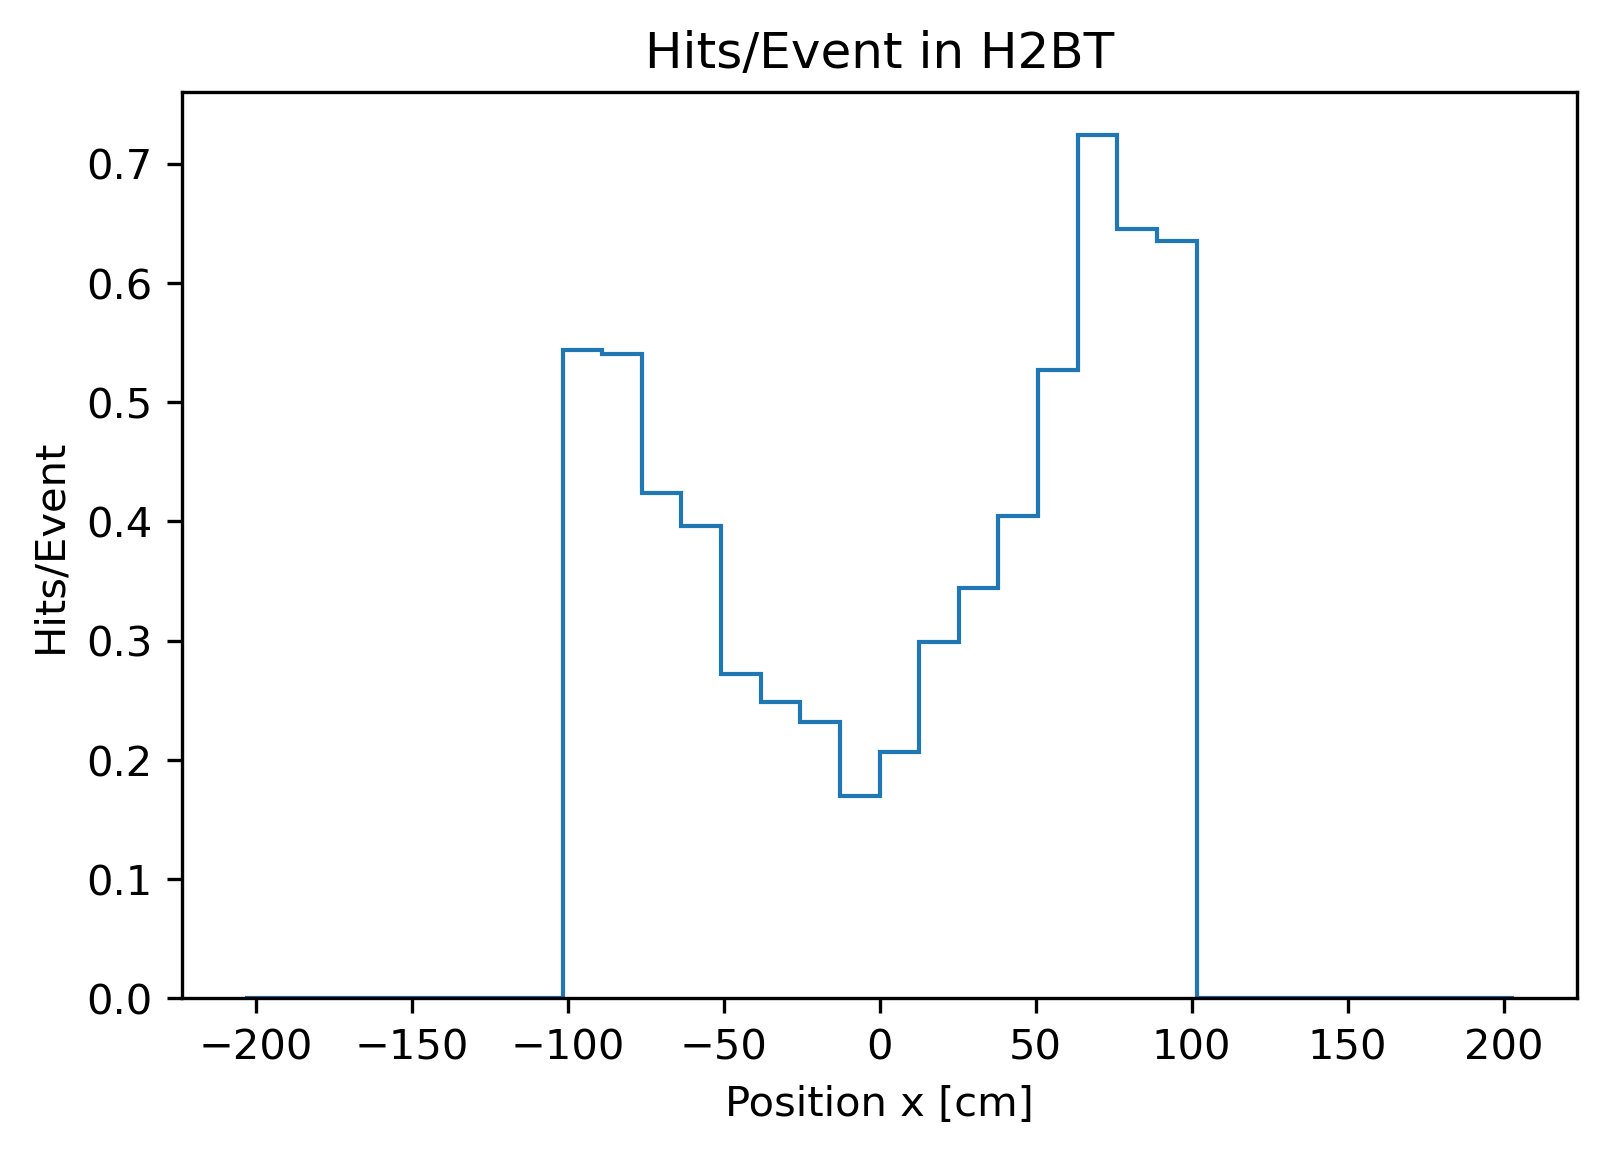

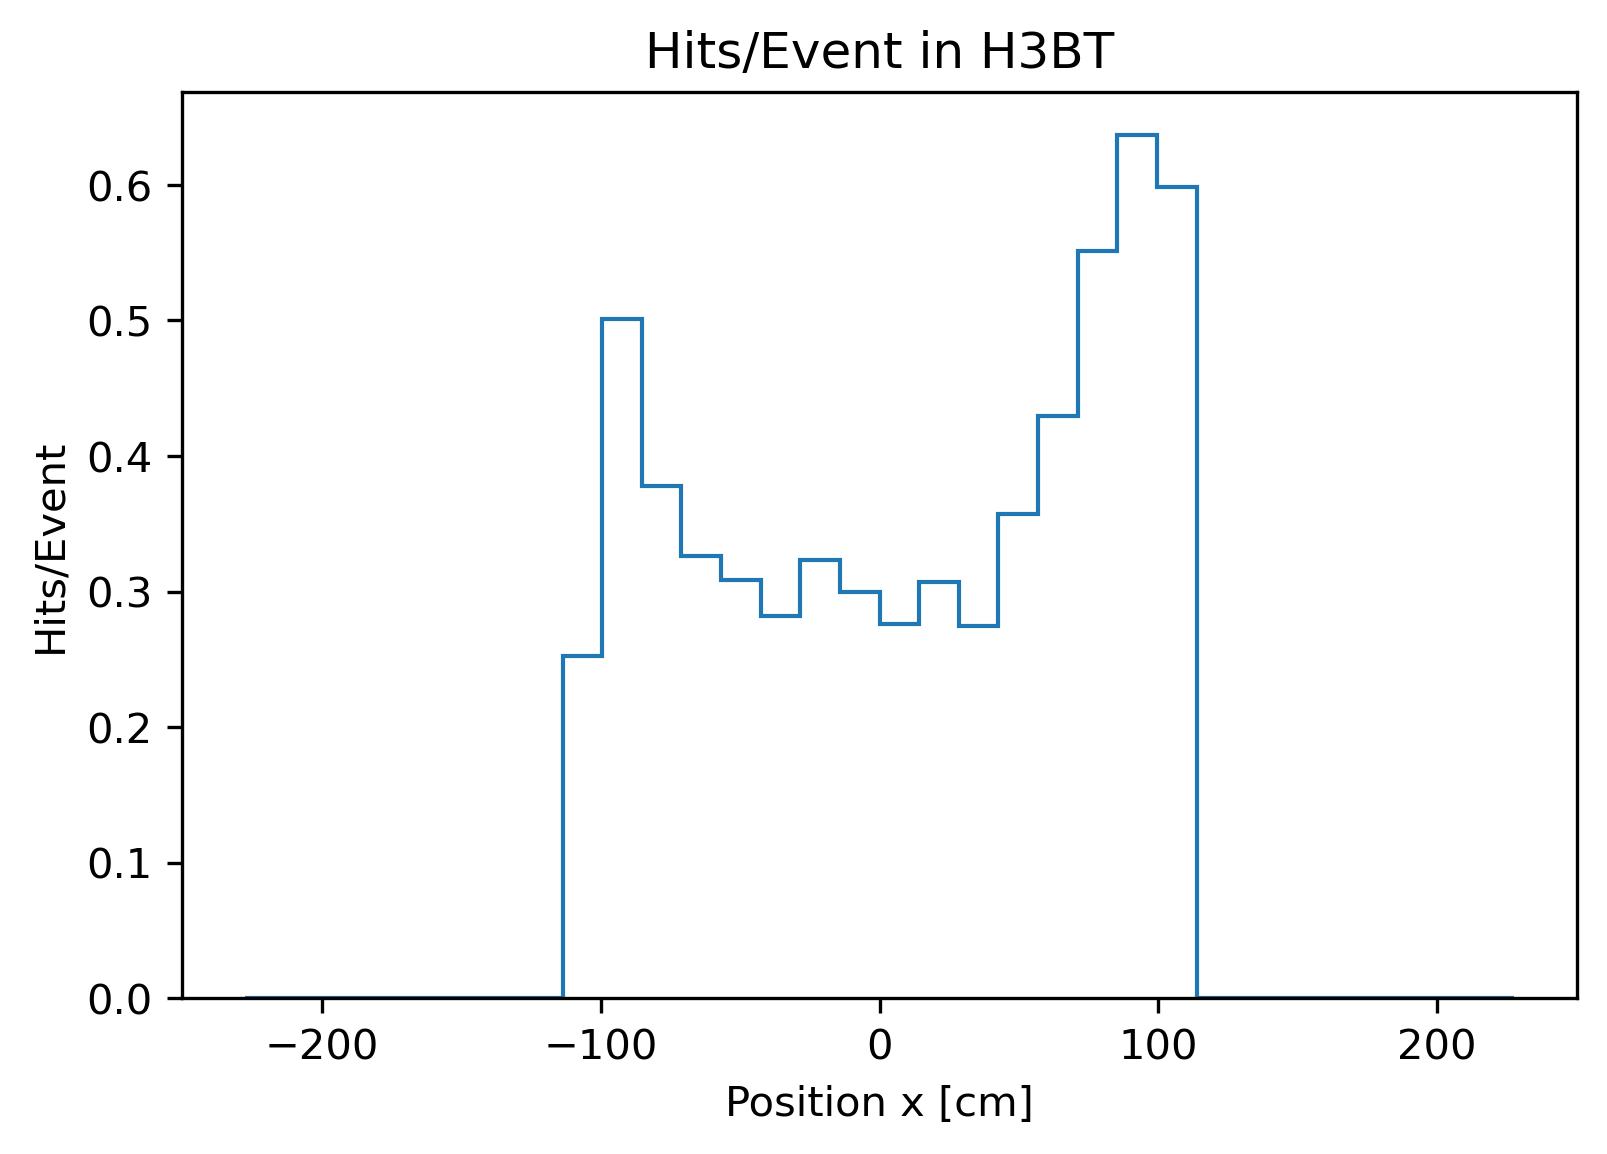

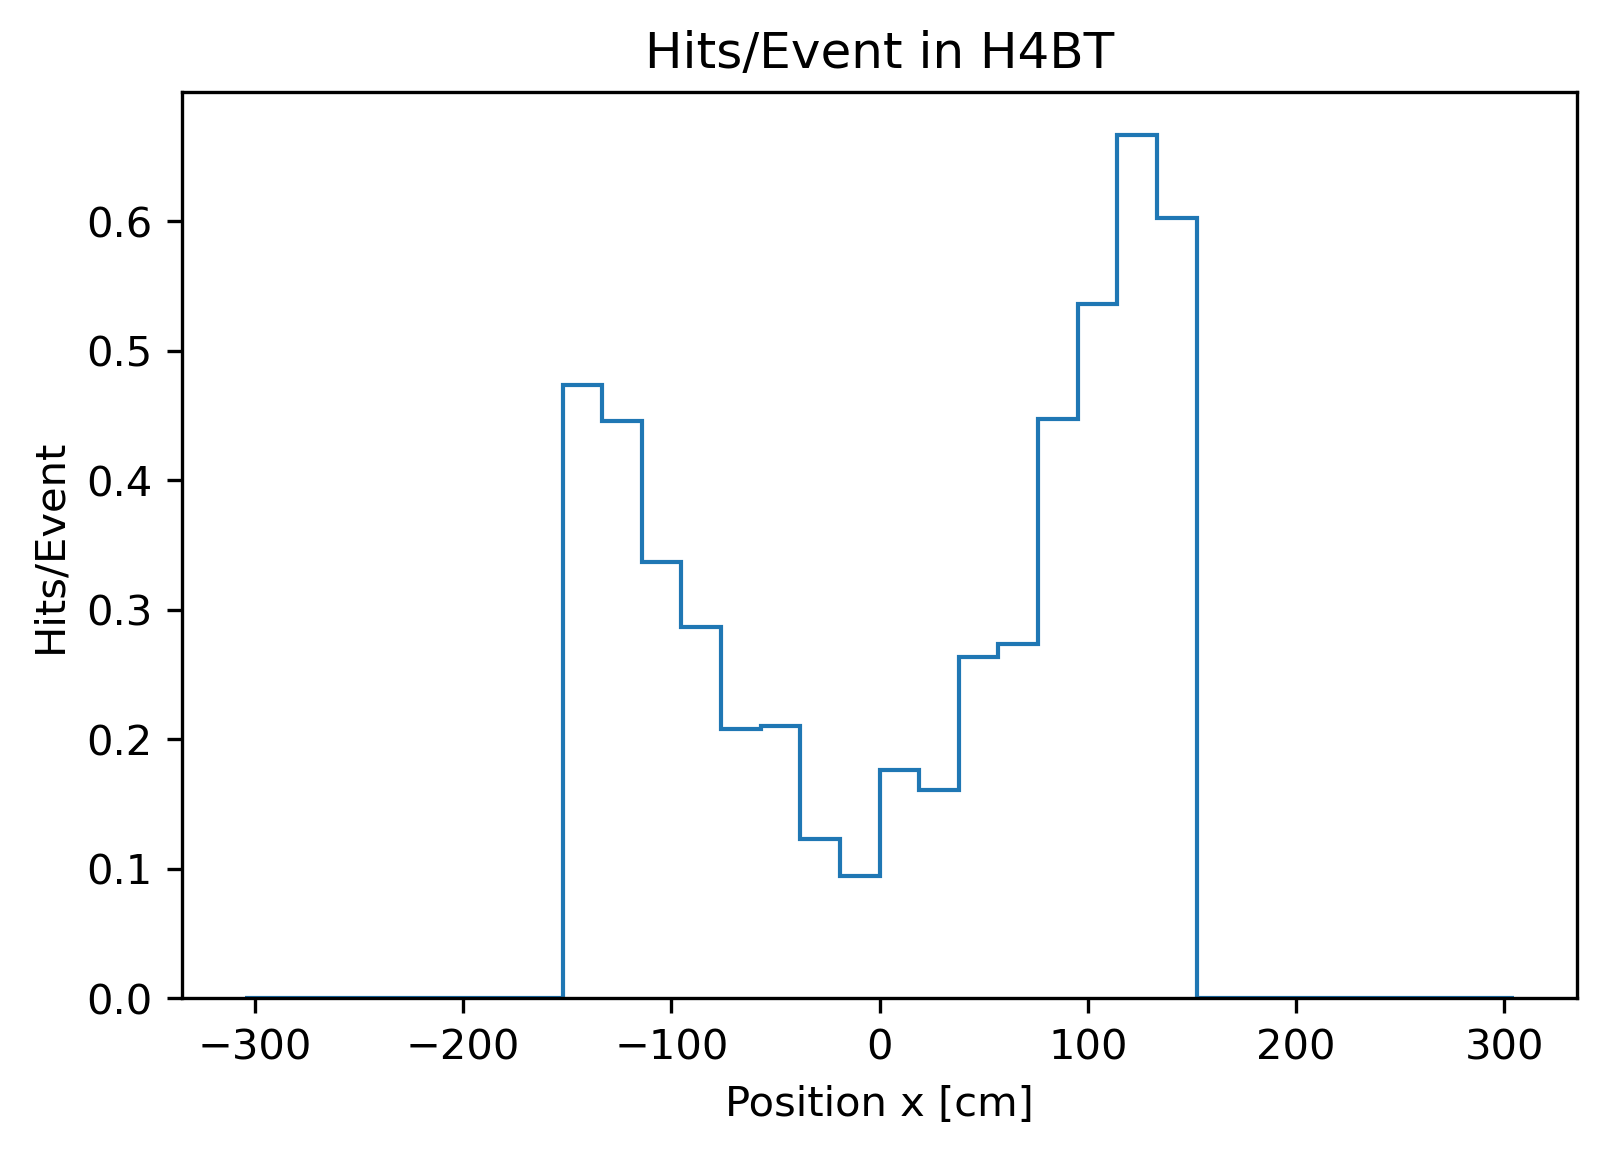

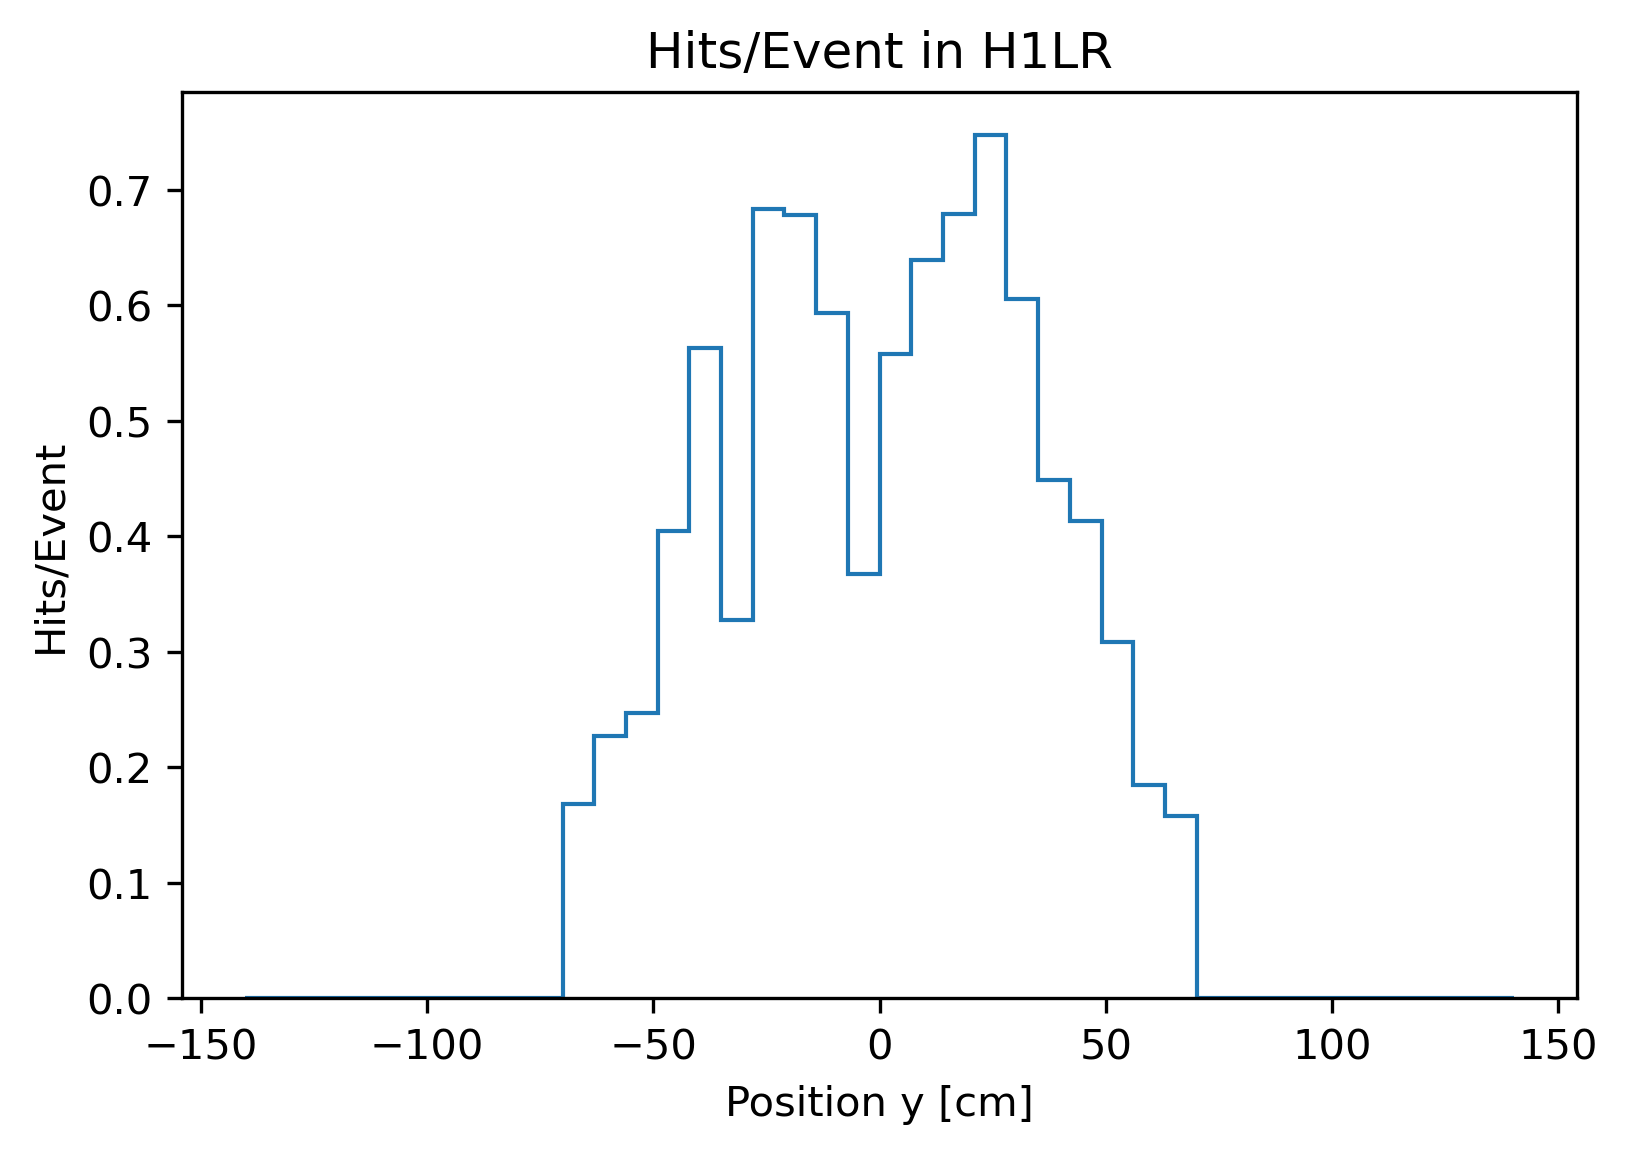

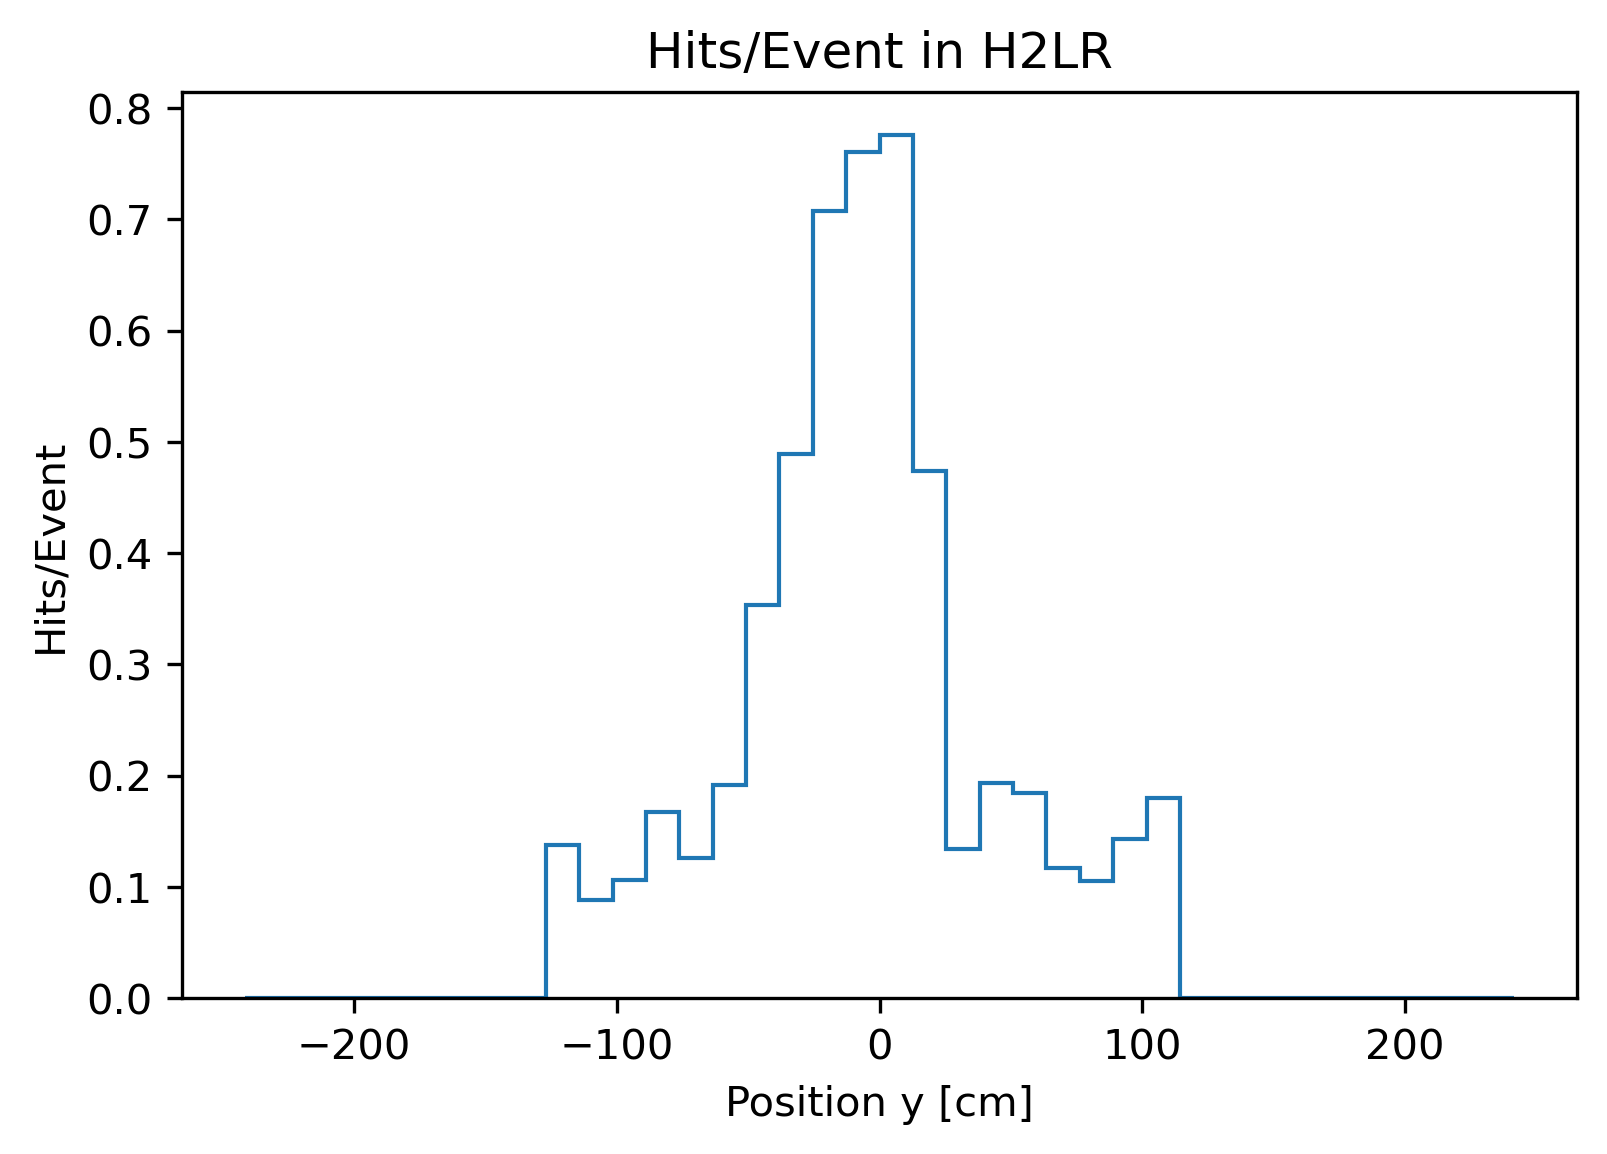

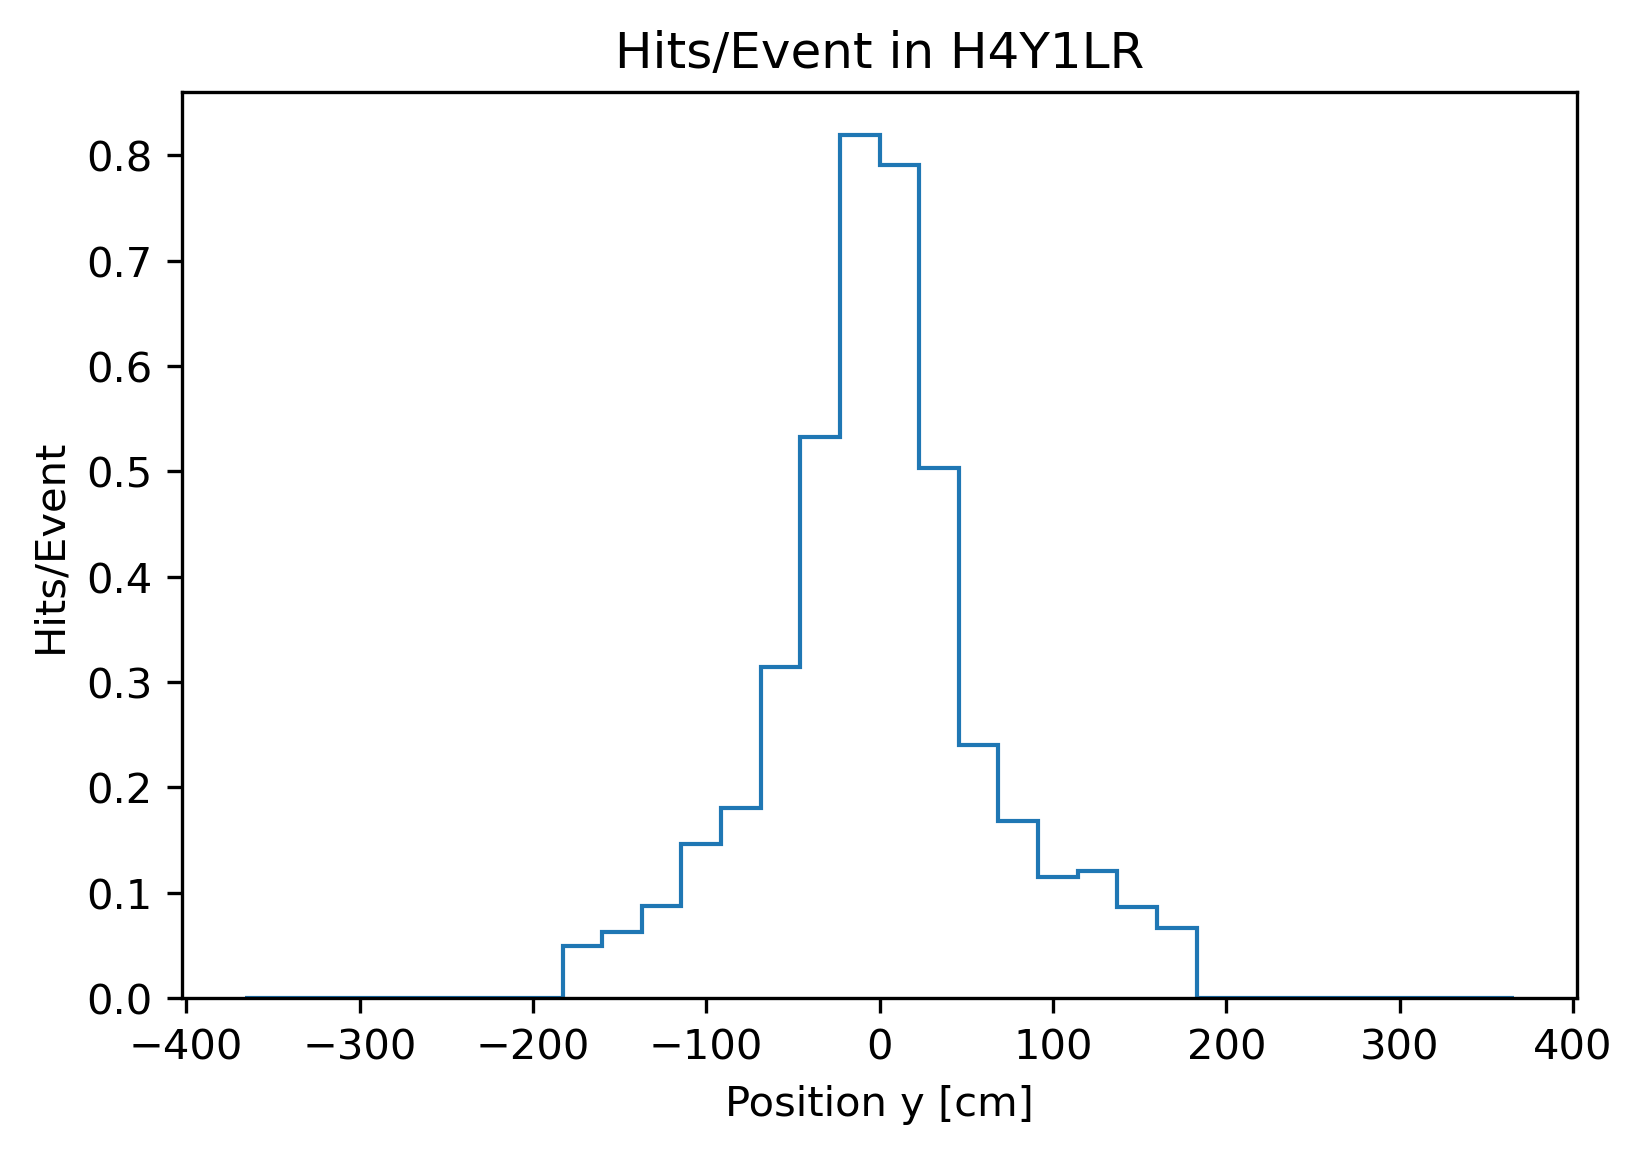

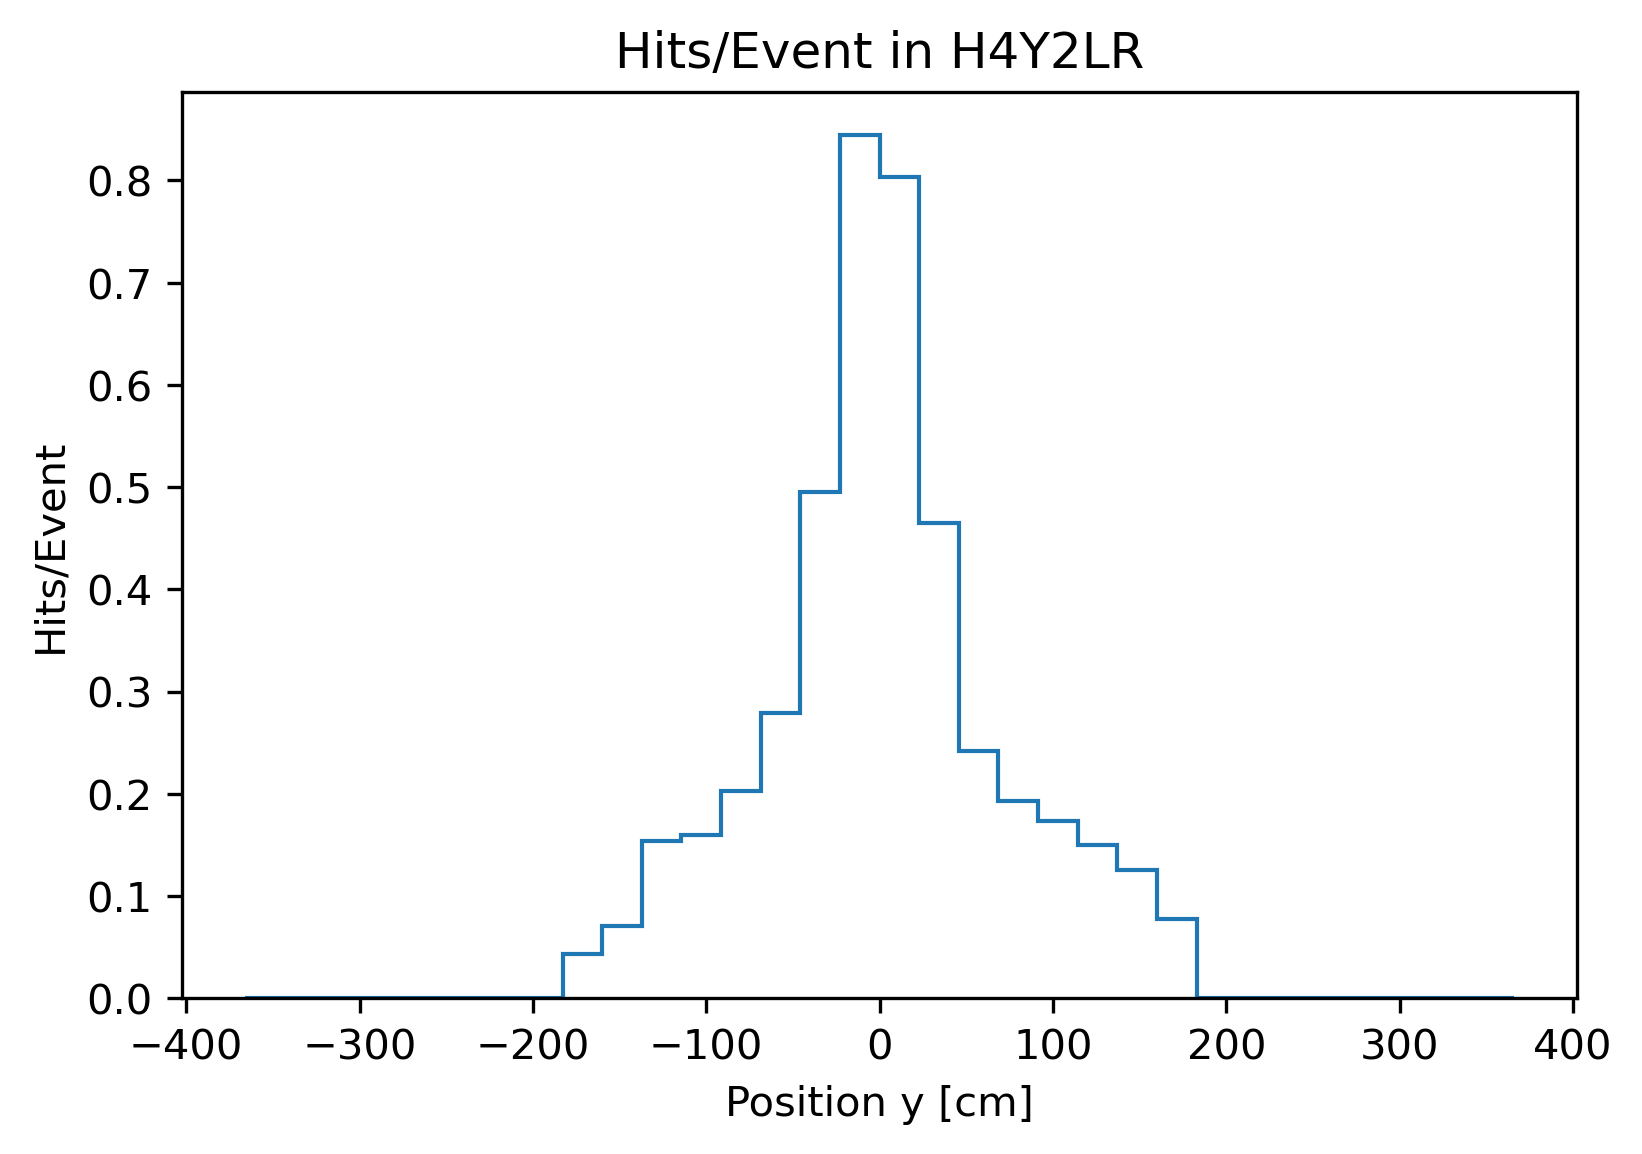

In [19]:
plotHodos(root)

# Plotting Drift Chambers

Each drift chamber (DC) has six associated detectorIDs, one for each of the planes:

<img src="files/DC_IDs.JPG">

* Two `x'` planes aligned with the vertical 
* Two `U` planes and two `V` planes aligned $\pm 14^{\circ}$ wrt the vertical.

Therefore, when plotting the drift chambers I will consider only the detectorIDs along the `x'` plane:

DetectorIDs (x-plane):
* **D0:** 3, 4
* **D1:** 9, 10
* **D2:** 15, 16
* **D3p:** 21, 22
* **D3m:** 27, 28

**Need DC geometry to develop proper plotting routine**